## Deep Learning (Lab Sections 1 & 2)

In [29]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

print("Hello to Deep Learning")

Hello to Deep Learning


### Installing some main torch library and other essential tools.
There are a number of imports for torch. (These are not included with ISLP, so must be installed separately.) All of them are used to specify sequentially-structured networks.

In [30]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,R2Score)
from torchinfo import summary

 The package pytorch_lightning is a somewhat higher-level interface to torch that simplifies the specification and fitting of models by reducing the amount of boilerplate code needed (compared to using torch alone).

In order to reproduce results we use seed_everything(). We will also instruct torch to use deterministic algorithms where possible.

In [31]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
#We will use several datasets shipped with torchvision for our examples
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
# The glob() function from the glob module is used to find all files matching wildcard characters
from glob import glob
import json

Seed set to 0


In [32]:
Hitters = load_data('Hitters').dropna()
print(Hitters.shape)
n = Hitters.shape[0]

(263, 20)


We will fit two linear models (least squares and lasso) and compare their performance to that of a neural network. For this comparison we will use mean absolute error on a validation dataset. In tools like ModelSpec (from the ISLP library), the design matrix allows you to specify transformations, interaction terms, and polynomial expansions of features.

It also allows machine learning models to understand and process the input data as well handle categorical variables (using one-hot encoding).Overall, fit_transform() in ModelSpec automates the creation of a design matrix, preparing data for machine learning models by fitting and transforming it in one step​.

In [33]:
model = MS(Hitters.columns.drop('Salary'),intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()
model

ModelSpec(intercept=False,
          terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))

The to_numpy() method above converts pandas data frames or series to numpy arrays. We do this because we will need to use sklearn to fit the lasso model, and it requires this conversion. We now split the data into test and training, fixing the random state used by sklearn to do the split.

In [34]:
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)
# X_train.shape
# X_test.shape
# Y_train.shape

### Linear Models

We fit the linear model and evaluate the test error directly.   

In [35]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146294

Next we fit the lasso using sklearn. We are using mean absolute error to select and evaluate a model, rather than mean squared error. 
Pipeline is a scikit-learn class used to chain multiple steps together. In this case, it chains standardization and Lasso regression into a single workflow.

In [36]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100))
             * lam_max}
# param_grid
# lam_max

lam_max is the value of the regularization parameter (lambda) beyond which all coefficients in the Lasso regression model would be shrunk to zero. It's essentially the highest level of regularization that would still allow some coefficients to remain non-zero.

We also now perform cross validation using this sequence of tuning regularization parameter (lambda) values.The 'param_grid' can be used in conjunction with GridSearchCV to find the optimal value of lambda for Lasso regression:

In [37]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(standard_lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);
# grid

We extract the lasso model with best cross-validated mean absolute error, and evaluate its performance on X_test and Y_test, which were not used in cross-validation.

In [38]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

235.6754837478029

### Specifying a Neural Network: Classes and Inheritance
To fit the neural network, we first set up a model structure that describes the network. Doing so requires us to define new classes specific to the model we wish to fit. Typically this is done in pytorch by sub-classing a generic representation of a network, which is the approach we take here.

In [39]:
#specifying network architecture
class HittersModel(nn.Module): #this class inherits from nn.module

    #create objects  
    def __init__(self,input_size):
        super(HittersModel,self).__init__()
        self.flatten = nn.Flatten()
        #nn.Sequential is a container that holds layers in sequence. 
        #The input data flows through these layers one by one.
        self.sequential = nn.Sequential(
            nn.Linear(input_size,50), # Fully connected layer: input -> 50 neurons
            nn.ReLU(), 
            nn.Dropout(0.4), # Dropout with a probability of 0.4
            nn.Linear(50,1) # Fully connected layer: 50 -> output 1 neuron
        )

    def forward(self,x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

This defines a simple feedforward neural network (single hidden layer) with 50 neurons in the hidden layer and a ReLU activation function, followed by dropout and a final output layer. The class above inherits from nn.module base class.

The __init__ method creates instances of the hitters model class and has two model attributes flatten and sequential which are used in the forward method. 'super()' allows subclasses (i.e. HittersModel) to access methods of the class they inherit from. 

In the sequential attribute, the input data flows through all the layers (along with applied functions) we define one by one such as the Rectified Linear Activation Function,40% dropout layer and hidden layer(s) (here size -> 50 and features are 19).All these layers are mapped to one another.

In [40]:
hit_model = HittersModel(X.shape[1])
hit_model

HittersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=19, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)

The package torchinfo provides a summary() function that neatly summarizes this information. We specify the size of the input and see the size of each tensor as it passes through layers of the network.

In [41]:
summary(hit_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

Now we wish to see the final results (i.e. the error metrics) of this neural network and should be expecting some good answers (compared to the previous models) as there is quite a lot of parameters.

Since the data is a bit different, i.e. the datatypes are not tensors which are the basic DT in torch, we need to convert it to a more accesible form.As usual we again create a test and training dataset split, this time using the TensorDataset function.


In [42]:
X_train_t = torch.tensor(X_train.astype(np.float32)) # numpy array(s)
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

#test data
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

max_num_workers = rec_num_workers()

Finally, this dataset is passed to a DataLoader() which ultimately passes data into our network. While this may seem like a lot of overhead, this structure is helpful for more complex tasks where data may live on different machines, or where data must be passed to a GPU. We provide a helper function SimpleDataModule() provided in ISLP to make this task easier for standard usage.

We now use this to tell torch how to read in the data for Stochastic gradient descent.We provide the training and test data sets as well as the batch size (of 32) and a validation set (test set only in this case).The parameter 'num_workers' indicates how many processes we will use for loading the data.

By using the SimpleModule.regression() method, we indicate that we will use squared-error loss.We have also asked for mean absolute error to be tracked as well in the metrics that are logged.

The whole process might feel cumbersome but tends to repeat itself and can be redone after the steps are understood.

In [43]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

#prediction and measuring squared error loss
hit_module = SimpleModule.regression(hit_model,metrics={'mae':MeanAbsoluteError()})

# We can log our results via CSVLogger(), which in this case stores the results in a CSV file within a directory logs/hitters
hit_logger = CSVLogger('logs', name='hitters')

Now we are finally ready to train our model and put everything together to run stochastic gradient descent.We provide some logging details and maximum no of epochs information in the Trainer method (object from pytorch_lightning).The callback argument uses the helper function ErrorTracker() to track the error/loss (at every epoch) in our logs and we use this to make plots as we go along the epochs. 

In [44]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])

hit_trainer.fit(hit_module,datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s, v_num=1]
Validation: |                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 126.09it/s, v_num=1]
Validation: |                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 151.21it/s, v_num=1]
Validation: |                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.18it/s, v_num=1]


After having fit the model, we can evaluate performance on our test data using the test() method of our trainer.

In [45]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             104098.5546875
        test_mae            229.50115966796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.5546875, 'test_mae': 229.50115966796875}]

We can see that MAE has reduced to 229.50 compared to the 259 and 237 we had earlier for OLS and Lasso Regression and it's a quite a better result.

Now earlier we had made a CSV logger to log the data and errors.Now that nicely gives the logs in the form of a csv file that can be loaded with pandas dataframe.We can use that to make a few meaningful plots such

In [46]:
#retrieving the logs
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)
hit_results

,epoch,step,test_loss,test_mae,train_loss,train_mae_epoch,train_mae_step,valid_loss,valid_mae
0,0,4,NaN,NaN,NaN,NaN,386.986084,NaN,NaN
1,0,5,NaN,NaN,NaN,NaN,NaN,145063.593750,237.685242
2,0,5,NaN,NaN,715415.250000,561.457336,NaN,NaN,NaN
3,1,9,NaN,NaN,NaN,NaN,273.843872,NaN,NaN
4,1,11,NaN,NaN,NaN,NaN,NaN,131679.781250,236.432709
...,...,...,...,...,...,...,...,...,...
156,49,294,NaN,NaN,NaN,NaN,338.384491,NaN,NaN
157,49,299,NaN,NaN,NaN,NaN,198.867279,NaN,NaN
158,49,299,NaN,NaN,NaN,NaN,NaN,104098.554688,229.501160
159,49,299,NaN,NaN,108526.789062,236.133484,NaN,NaN,NaN


Since we will produce similar plots in later examples, we write a simple generic function to produce this plot.

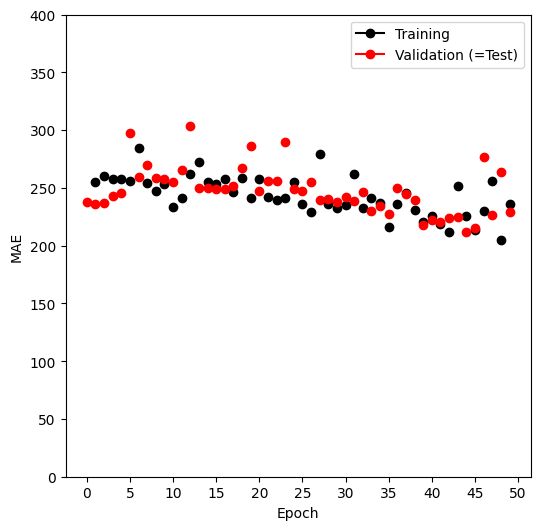

In [47]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax
# We now set up our axes, and use our function to produce the MAE plot.

fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

Probably we didn't need to go on for 50 epochs as the errors settled down pretty quickly.Also we can say that we also haven't overfitted much as the model wasn't that complex.

Now we can predict directly from the final model, and evaluate its performance on the test data. Before fitting, we call the eval() method of hit_model. This tells torch to effectively consider this model to be fitted, so that we can use it to predict on new data. For our model here, the biggest change is that the dropout layers will be turned off, i.e. no weights will be randomly dropped in predicting on new data.

In [48]:
hit_model.eval() 
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5012, grad_fn=<MeanBackward0>)

Finally we do a little bit of cleanup, deleting torch objects which are not required (to ensure that these processes will be killed).Several worker processes will still remain running.

In [49]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

## Multilayer Network on the MNIST Digit Data
The torchvision package comes with a number of example datasets, including the MNIST digit data. Our first step is to retrieve the training and test data sets; the MNIST() function within torchvision.datasets is provided for this purpose. The data will be downloaded the first time this function is executed, and stored in the directory data/MNIST.

This dataset contains handwritten digits on postal codes that we are trying to classify into the 10 digits classes.

In [51]:
(mnist_train, 
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 3404527.17it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 141770.54it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1870873.96it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 253021.95it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

There are 60,000 images in the training data and 10,000 in the test data. The images are 28*28 dimensionally and stored as a matrix of pixels. We need to transform each one into a vector.Also scaling of the inputs is done by ToTensor()

As in our Hitters example, we form a data module from the training and test datasets, setting aside 20% of the training images for validation and having a batch size of 256.

In [57]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)
# mnist_dm
# Let’s take a look at the data that will get fed into our network. We loop through the first few chunks of the test dataset, breaking after 2 batches:

for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

#Each batch has 256 images of size 1*28*28

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


Now we are good to structure our neural network (multi-layer).This simply describes the features are simply transformed into the 10 outputs and then gets put in the softmax function.

In [63]:
class MNISTModel(nn.Module):
    def  __init__(self):
        super(MNISTModel,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
        
    def forward(self, x):
        return self._forward(x)

We see that in the first layer, each 1x28x28 image is flattened, then mapped to 256 dimensions where we apply a ReLU activation with 40% dropout. A second layer maps the first layer’s output down to 128 dimensions, applying a ReLU activation with 30% dropout. Finally, the 128 dimensions are mapped down to 10, the number of classes in the MNIST data.

A lot of the below part is identical to the SNN example, where we check the parameters, fit the network and train it using Stochastic Gradient Descent.

In [64]:
mnist_model = MNISTModel()
mnist_model(X_).size()

# We can check that the model produces output of expected size based on our existing batch X_ above.

torch.Size([256, 10])

In [65]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In contrast to our regression model, here we will use the SimpleModule.classification() method which uses the cross-entropy loss function instead of mean squared error. It must be supplied with the number of classes in the problem.

In [67]:
mnist_module = SimpleModule.classification(mnist_model,
                                           num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

# The final step is to supply training data, and fit the model. We disable the progress bar below to avoid lengthy output in the browser when running.
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


We have suppressed the output here, which is a progress report on the fitting of the model, grouped by epoch. This is very useful, since on large datasets fitting can take time. Fitting this model took 170 seconds on a Windows 11 Device with 4 cores and 8 GB of RAM. Here we specified a validation split of 20%, so training is actually performed on 80% of the 60,000 observations in the training set.

SimpleModule.classification() includes an accuracy metric by default. Other classification metrics can be added from torchmetrics. We will use our summary_plot() function to display accuracy across epochs.

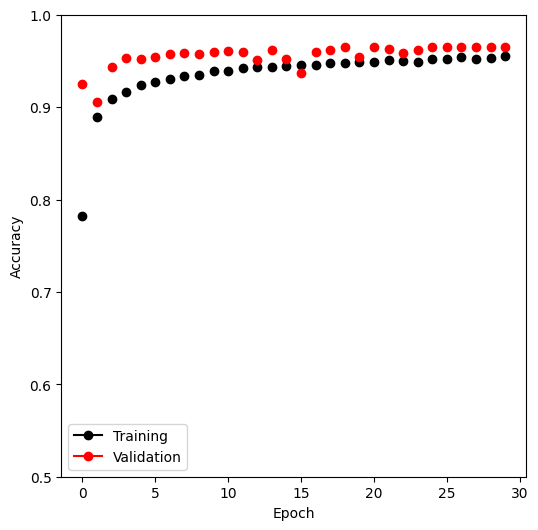

In [68]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

Here the metric uesd is accuracy and we can see how the graph progresses for both the training and validation data.Interestingly the validation data starts off a little higher than the training data but in the end they are almost comparable.

Once again we evaluate the accuracy using the test() method of our trainer.The accuracy comes out to be 96.67%.

In [69]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9666000008583069
        test_loss           0.15843795239925385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15843795239925385, 'test_accuracy': 0.9666000008583069}]

As in the Hitters example, we delete some of the objects we created above.

In [70]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results)